<a href="https://colab.research.google.com/github/JcDai/CSCI-GA-2271-001-Computer-Vision-Fall-2021/blob/main/multi_loss_with_circle_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Multi-Loss with Circle Loss Experiments

In [ ]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
tf.random.set_seed(123)

## Download the dataset


In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774638592/2774625282 [==============================] - 58s 0us/step


In [ ]:
# do not run this
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "train.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/train.tar.gz",
        extract=True,
    )

 4470898688/86747209190 [>.............................] - ETA: 1:21:40

KeyboardInterrupt: ignored

In [ ]:
annotation_folder = "/dataset/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "test.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/test.tar.gz",
        extract=True,
    )

##  Prepare the dataset

Use indoor images for this experiment

In [ ]:
#do not run this
path = "train/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df_train = pd.DataFrame(data)

df_train = df_train.sample(frac=1, random_state=42)

In [ ]:
len(df_train)

In [ ]:
#do not run this
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df_val = pd.DataFrame(data)

df_val = df_val.sample(frac=1, random_state=42)

In [ ]:
# run this 
path = "val/indoors"

filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)

df = df.sample(frac=1, random_state=42)

In [ ]:
len(df_val)

325

## Hyperparameters

In [ ]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 32

## Data Pipeline


In [ ]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y


## Visualizing samples

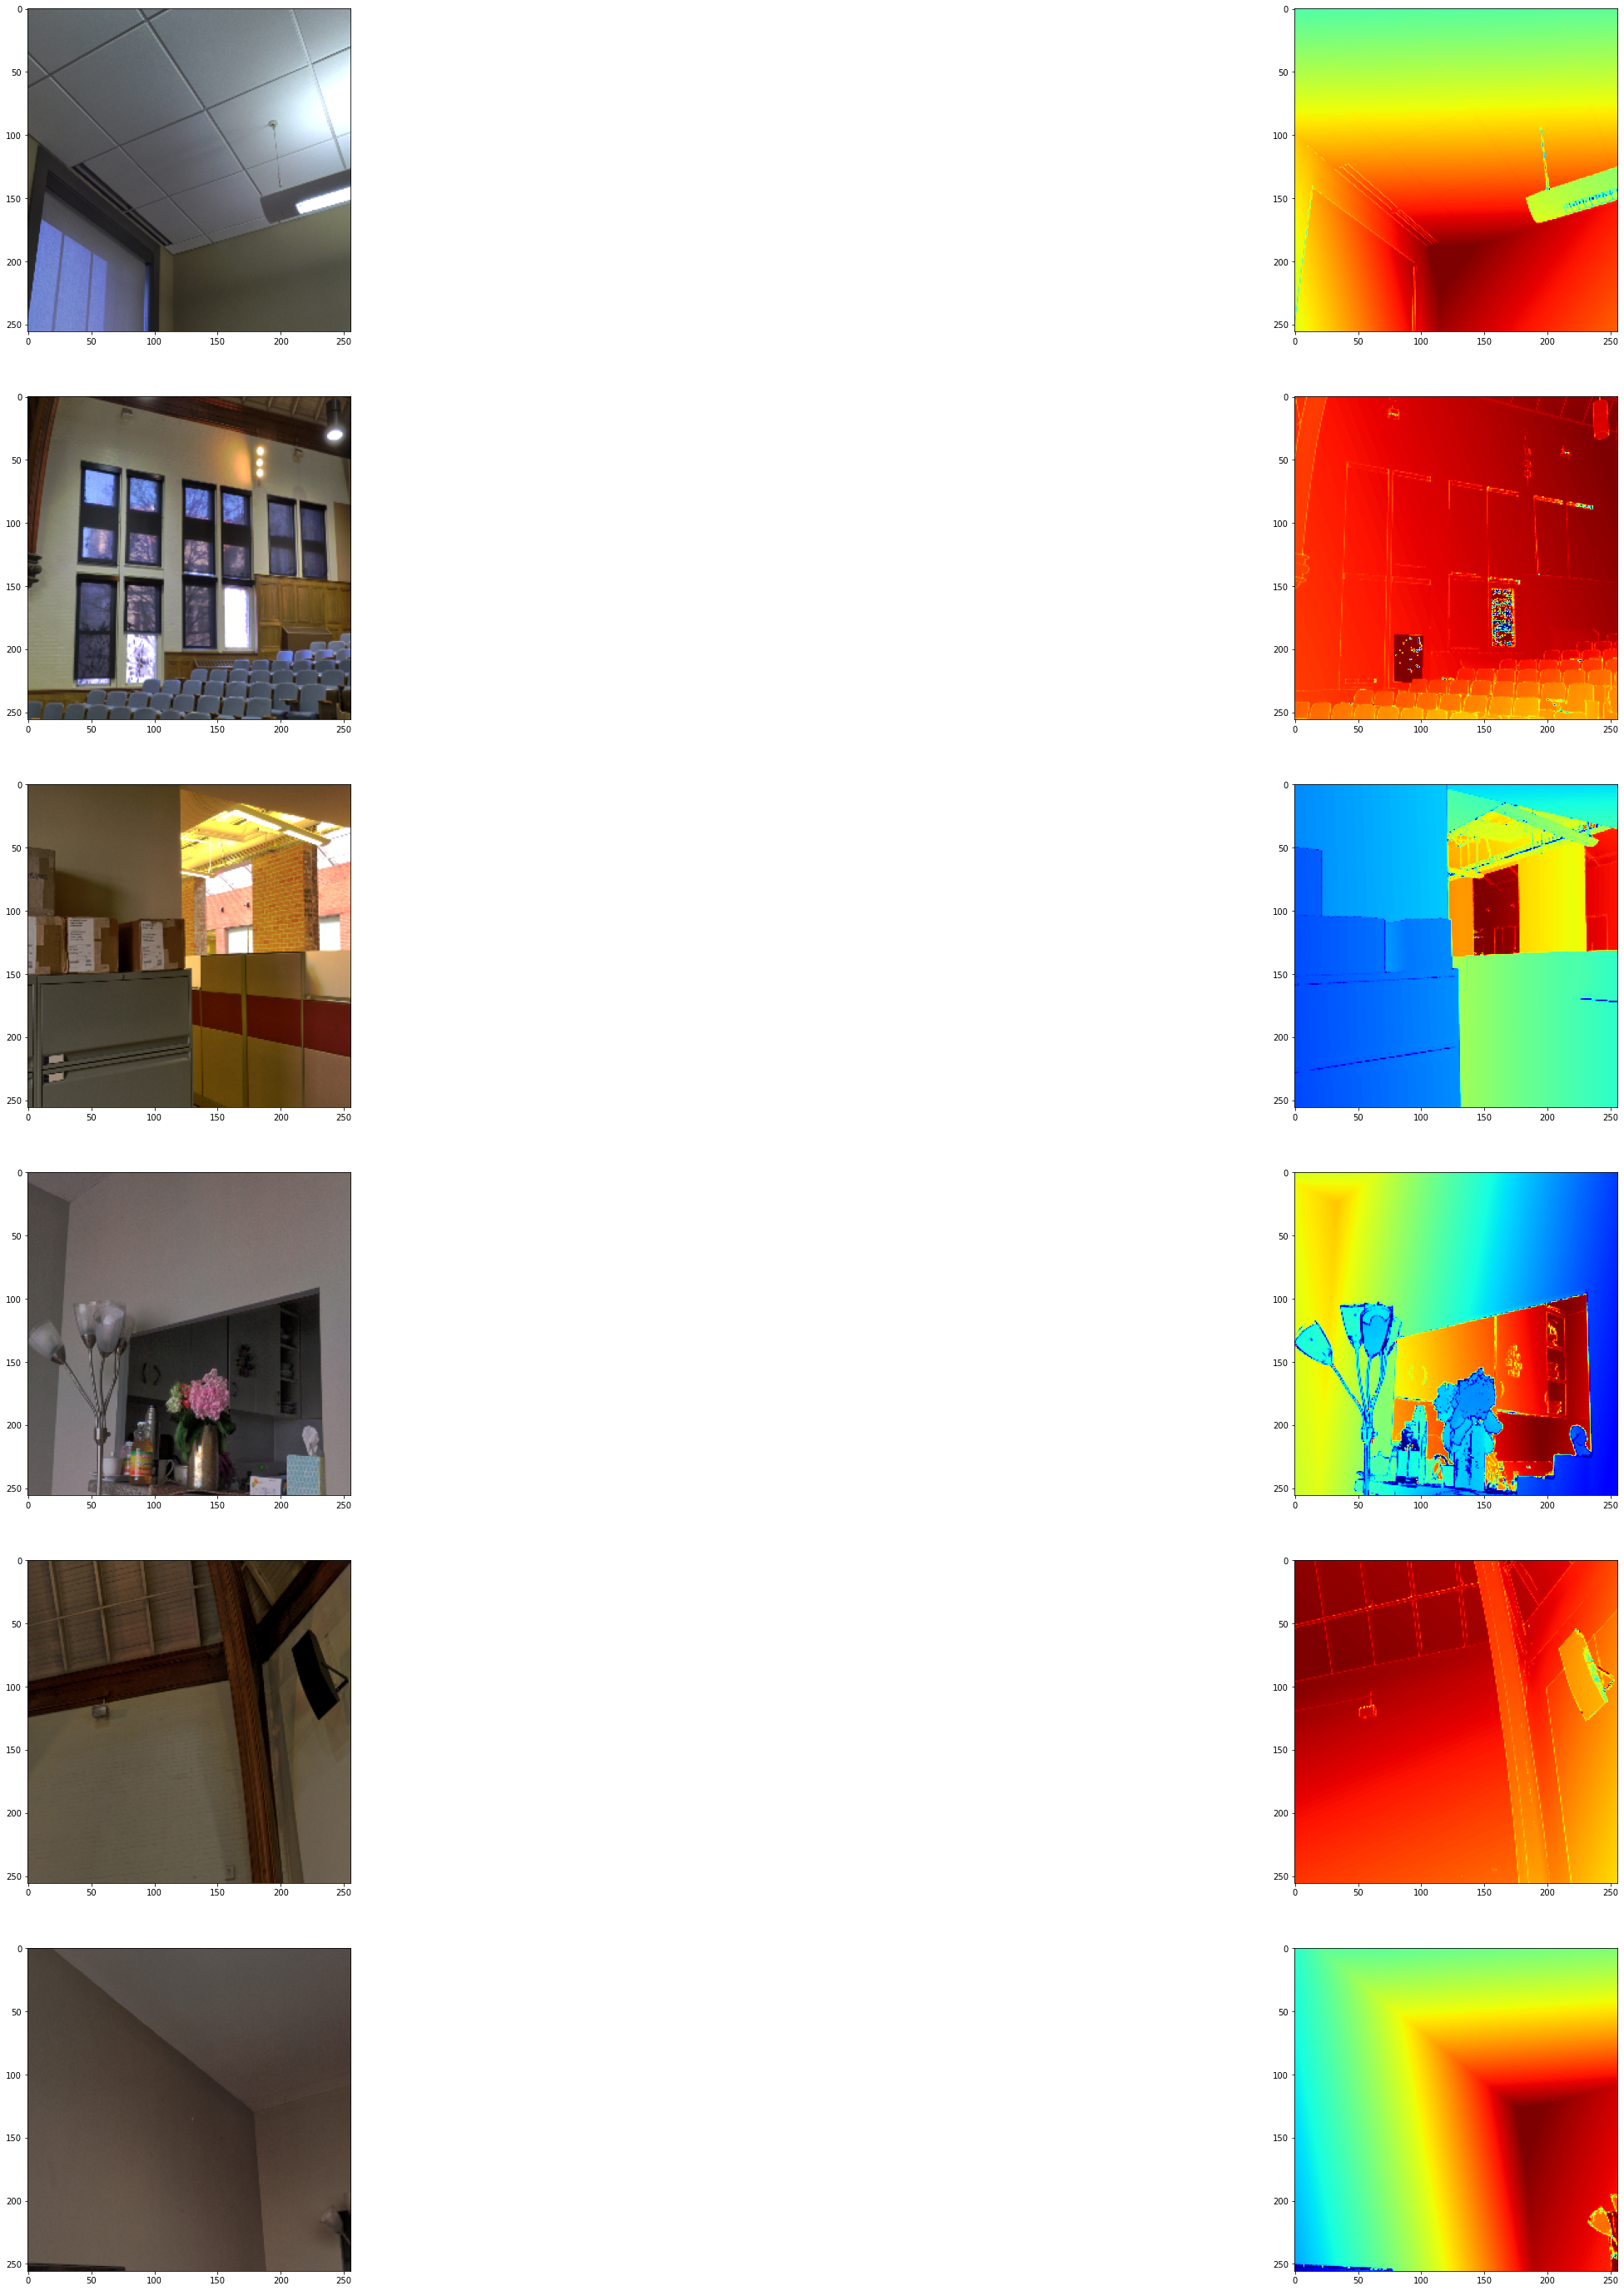

In [ ]:

def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

## U-Net

In [ ]:

class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


## Loss Functions

In [ ]:

class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


## Model training

In [ ]:
len(df_val)

In [ ]:
# do not run this
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df_train[325:1000].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df_val.reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
test_loader = DataGenerator(
    data=df_train[:325].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
model.fit(
    train_loader,
    epochs=10,
    validation_data=validation_loader,
)

NameError: ignored

In [ ]:
# run this

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

train_loader = DataGenerator(
    data=df[:265].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[266:280].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
# test_loader = DataGenerator(
#     data=df_train[:325].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
# )
model.fit(
    train_loader,
    epochs=10,
)

Epoch 1/10
9/9 [==============================] - 30s 2s/step - loss: 1.1304
Epoch 2/10
9/9 [==============================] - 7s 716ms/step - loss: 0.7918
Epoch 3/10
9/9 [==============================] - 7s 741ms/step - loss: 0.6677
Epoch 4/10
9/9 [==============================] - 3s 338ms/step - loss: 0.5944
Epoch 5/10
9/9 [==============================] - 3s 335ms/step - loss: 0.5355
Epoch 6/10
9/9 [==============================] - 3s 335ms/step - loss: 0.4828
Epoch 7/10
9/9 [==============================] - 3s 334ms/step - loss: 0.3858
Epoch 8/10
9/9 [==============================] - 4s 422ms/step - loss: 0.3801
Epoch 9/10
9/9 [==============================] - 1s 87ms/step - loss: 0.4742
Epoch 10/10
9/9 [==============================] - 1s 90ms/step - loss: 0.4584


## Visualize model output


In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=10, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

NameError: ignored

In [ ]:
def visualize_depth_map_4col(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 4, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((target[i*2].squeeze()), cmap=cmap)
            ax[i, 1].imshow((pred[i*2].squeeze()), cmap=cmap)
            ax[i, 2].imshow((target[i*2+1].squeeze()), cmap=cmap)
            ax[i, 3].imshow((pred[i*2+1].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

IndexError: ignored

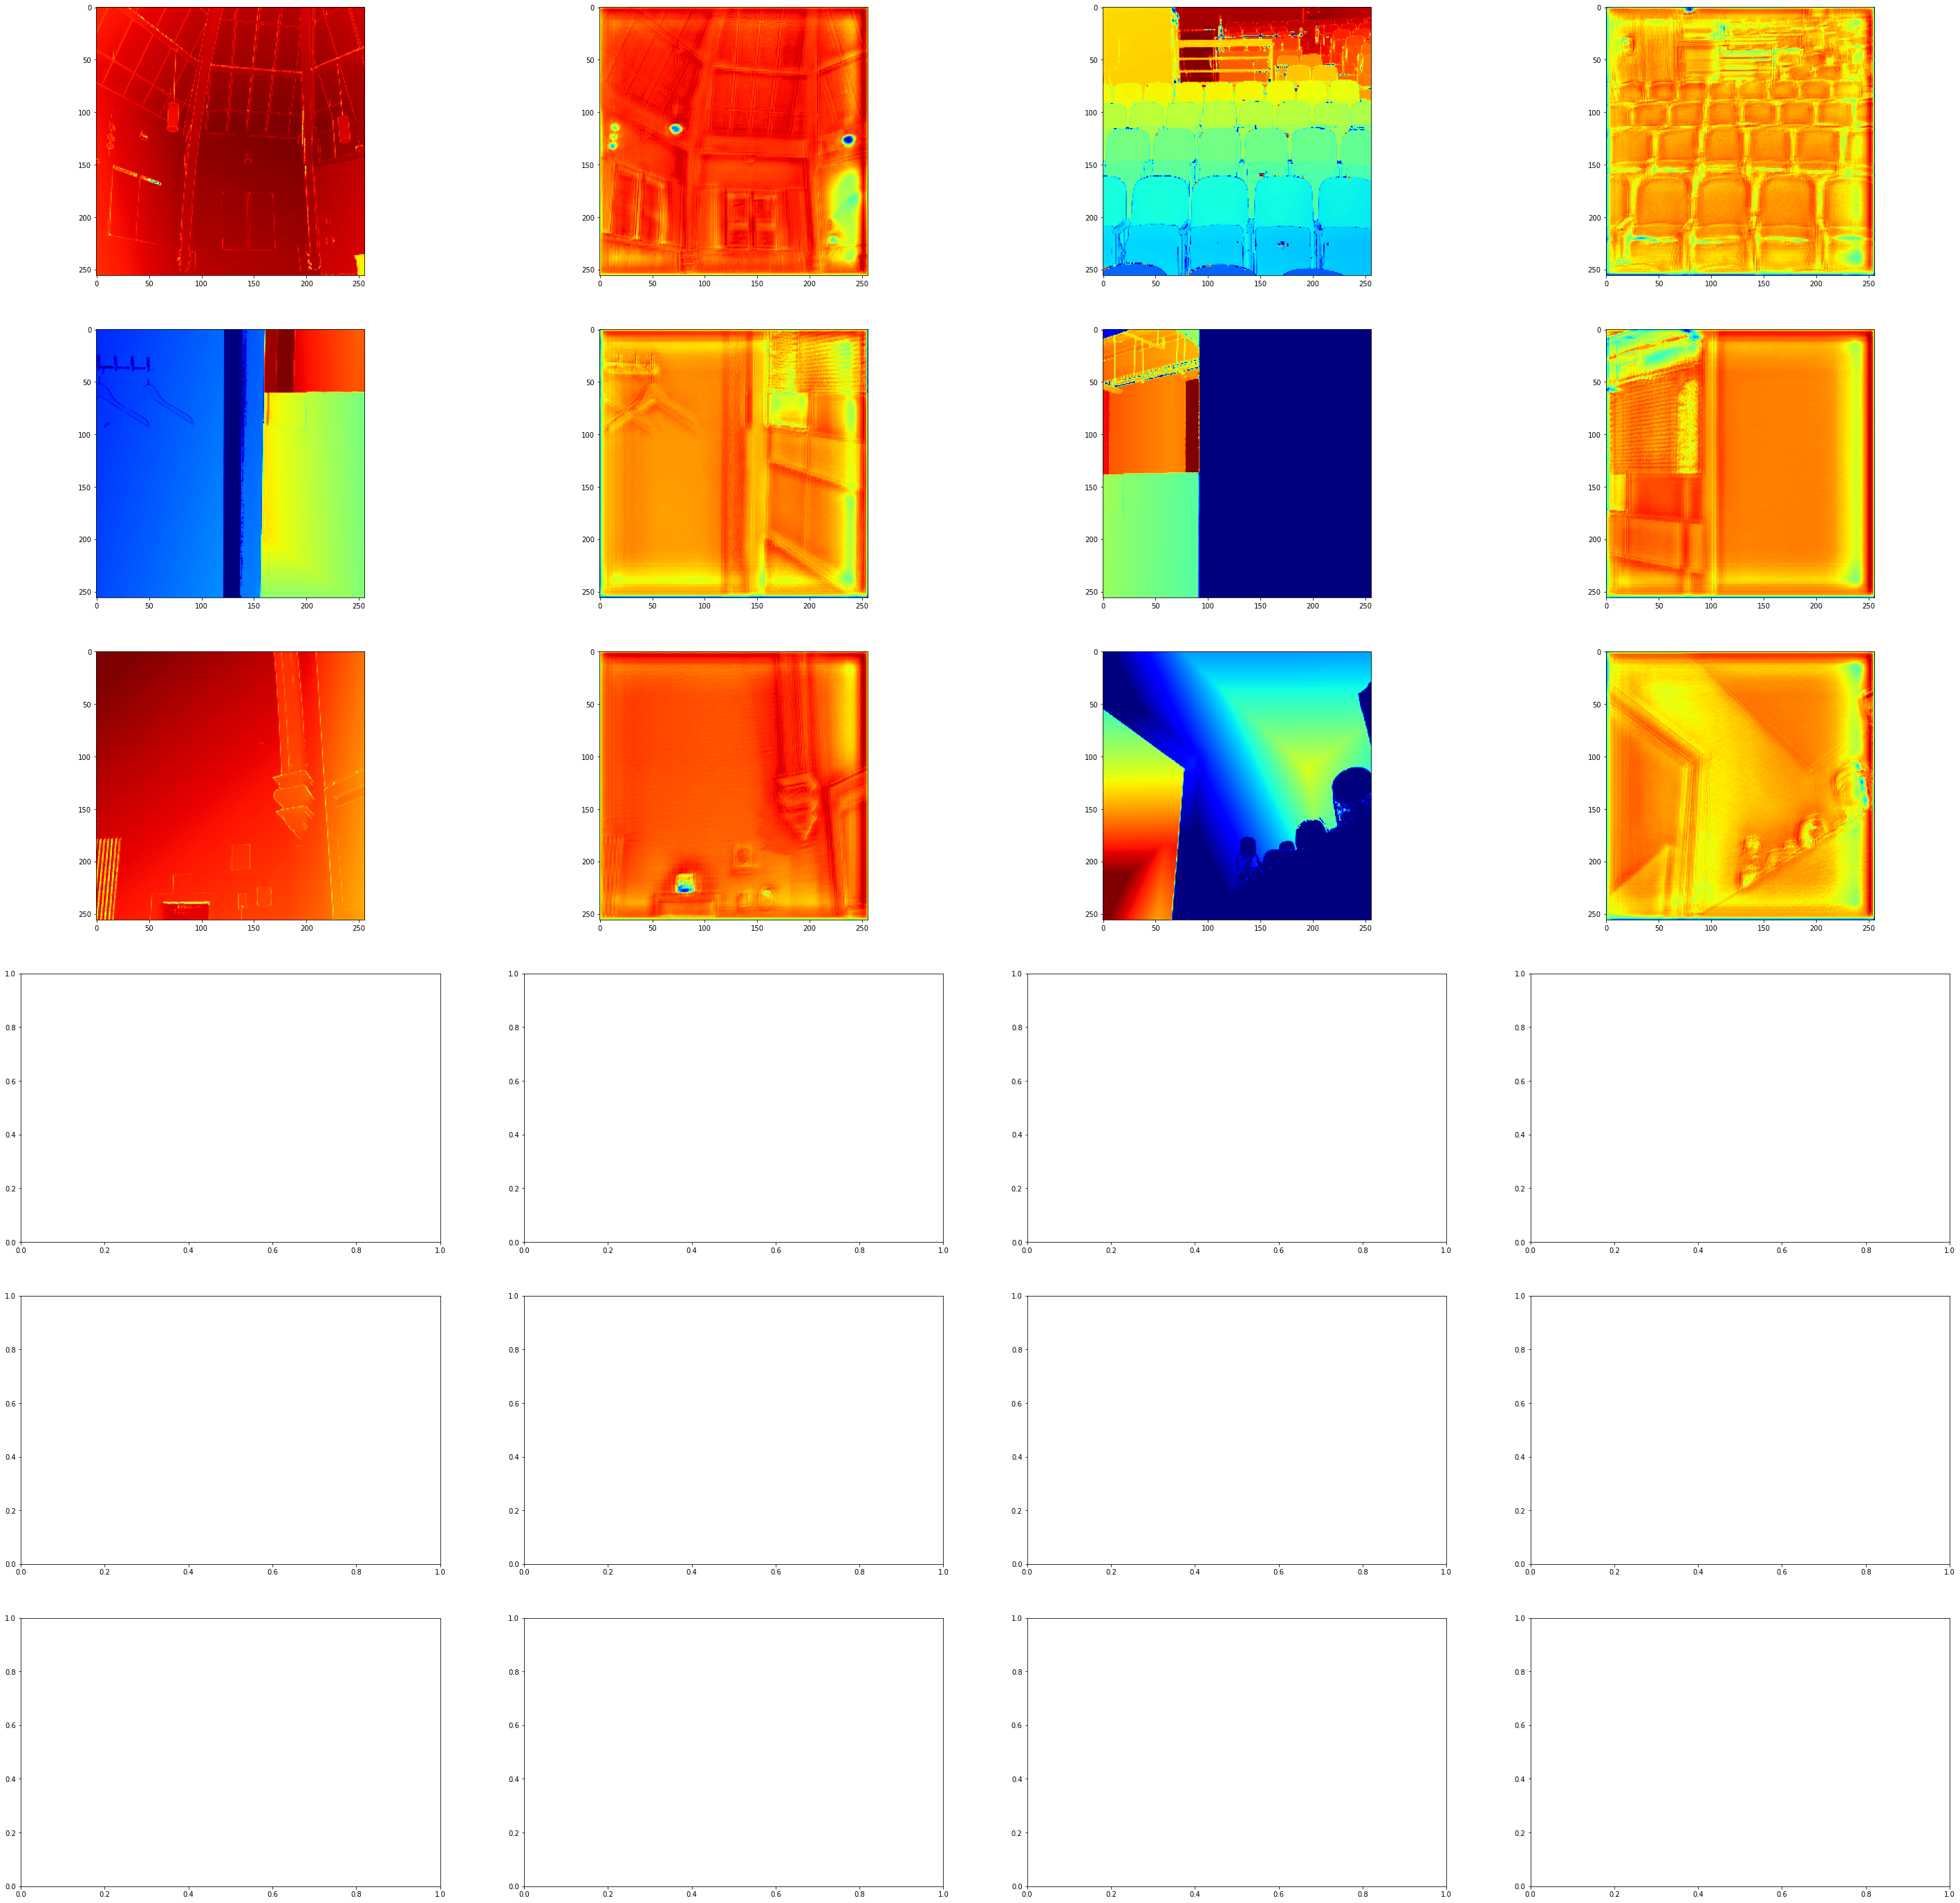

In [ ]:
# test_loader = next(
#     iter(
#         DataGenerator(
#             data=df_val[265:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
#         )
#     )
# )
# visualize_depth_map(test_loader, test=True, model=model)

test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
# visualize_depth_map(test_loader, test=True, model=model)
visualize_depth_map_4col(test_loader, test=True, model=model)

# Validation with RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def validate_rmse(pred, gt):
    rms = mean_squared_error(gt.squeeze(), pred.squeeze(), squared=False)
    return rms


In [ ]:
set_size = 300
data_loader = next(
    iter(
        DataGenerator(
            data=df[:300].reset_index(drop="true"), batch_size=set_size, dim=(HEIGHT, WIDTH)
        )
    )
)

inputs, targets = data_loader

In [ ]:
out_preds = []
rmse = []

for i in range(set_size):
    input, target = np.array([inputs[i]]), np.array([targets[i]])
    pred = model.predict(input)
    r = validate_rmse(pred, target)
    rmse.append(r)
    out_preds.append(pred[0])


In [ ]:
out_preds = np.array(out_preds)

In [ ]:
# print(out_preds[0].shape)
# print(out_preds[0])
print(out_preds.shape)
print(targets.shape)




(300, 256, 256, 1)
(300, 256, 256, 1)


# Generate Negative Samples

In [ ]:
eps = 0.01

diff = out_preds - targets
neg_samples = np.zeros(targets.shape)
neg_samples2 = np.zeros(targets.shape)

# for i in range(out_preds.shape[0]):
#     for j in range(out_preds.shape[1]):
#         for k in range(out_preds.shape[2]):
#             if(abs(diff[i][j][k][0])>eps):
#                 neg_samples[i][j][k][0] = targets[i][j][k][0] + diff[i][j][k][0]/abs(diff[i][j][k][0]) * eps

for i in range(out_preds.shape[0]):
    for j in range(out_preds.shape[1]):
        for k in range(out_preds.shape[2]):
            neg_samples[i][j][k][0] = targets[i][j][k][0] + eps
            neg_samples2[i][j][k][0] = targets[i][j][k][0] -  eps
            if(neg_samples[i][j][k][0]<0):
                neg_samples[i][j][k][0] = 0.001
            if(neg_samples2[i][j][k][0]<0):
                neg_samples2[i][j][k][0] = 0.001




In [ ]:
print(targets - neg_samples)

[[[[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  ...

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]]


 [[[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  ...

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]]


 [[[-0.01]
   [-0.01]
   [-0.01]
   ...
   [-0.01]
   [-0.01]
   [-0.01]]

  [[-0.

In [ ]:
# visualize negative sample

def visualize_neg_sample(targets, neg_samples, neg_samples2, start_idx=0):
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    fig, ax = plt.subplots(6, 3, figsize=(50, 50))
    for i in range(6):
        ax[i, 0].imshow((targets[i+start_idx].squeeze()), cmap=cmap)
        ax[i, 1].imshow((neg_samples[i+start_idx].squeeze()), cmap=cmap)
        ax[i, 2].imshow((neg_samples2[i+start_idx].squeeze()), cmap=cmap)

In [ ]:
print(targets - neg_samples)

[[[[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  ...

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]]


 [[[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  ...

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]]


 [[[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0.5]
   [-0.5]
   ...
   [-0.5]
   [-0.5]
   [-0.5]]

  [[-0.5]
   [-0

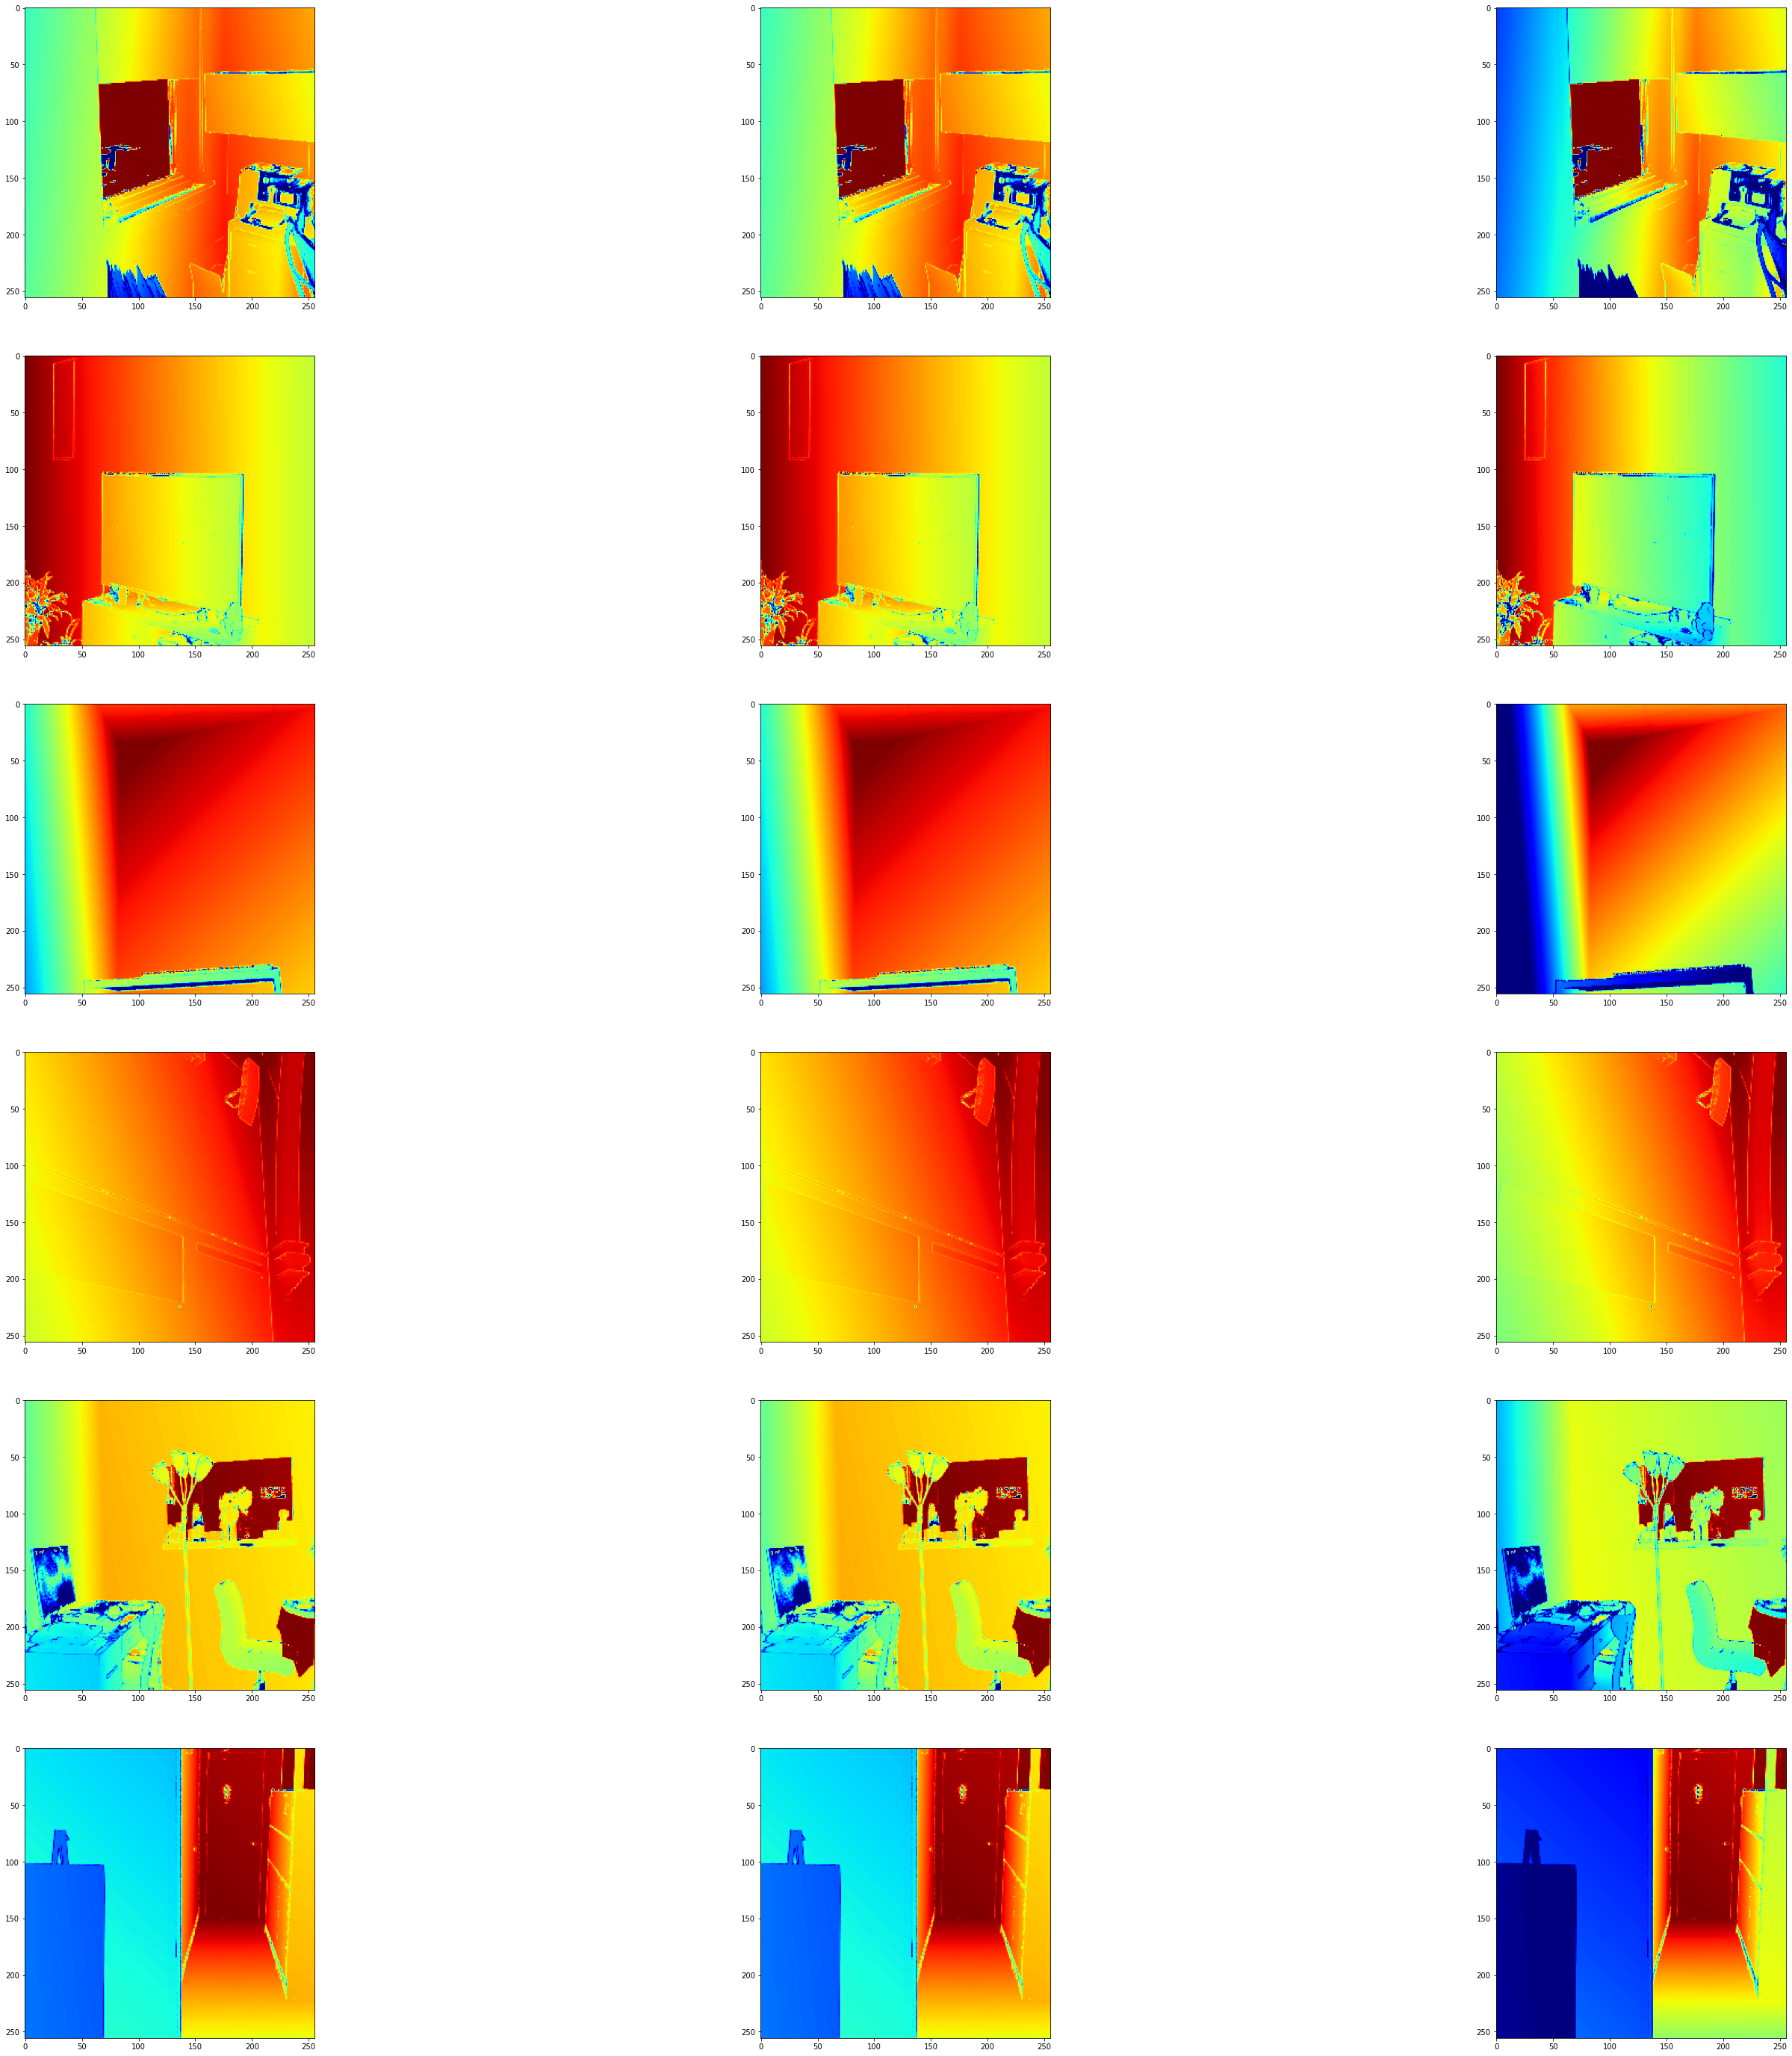

In [ ]:
visualize_neg_sample(targets, neg_samples, neg_samples2)

In [ ]:
neg_samples

array([[[[0.11      ],
         [0.11      ],
         [0.11      ],
         ...,
         [0.11      ],
         [0.11      ],
         [0.11      ]],

        [[0.11      ],
         [0.11      ],
         [0.11      ],
         ...,
         [0.11      ],
         [0.11      ],
         [0.11      ]],

        [[0.09      ],
         [0.11      ],
         [0.11      ],
         ...,
         [0.11      ],
         [0.11      ],
         [0.11      ]],

        ...,

        [[1.1225497 ],
         [1.1249835 ],
         [1.1277775 ],
         ...,
         [1.1638446 ],
         [1.1616421 ],
         [1.1593832 ]],

        [[1.1227036 ],
         [1.1252133 ],
         [1.1281223 ],
         ...,
         [1.1624395 ],
         [1.1602342 ],
         [1.1579745 ]],

        [[1.1225084 ],
         [1.1249827 ],
         [1.1281068 ],
         ...,
         [1.1614307 ],
         [1.1592383 ],
         [1.1572406 ]]],


       [[[0.3328033 ],
         [0.332269  ],
         [0.33

In [ ]:
# create new train_loader

# print(inputs.shape, targets.shape, neg_samples.shape)

# data

inputs4d = []
targets4d = []
neg_samples4d = []
neg_samples24d = []


for i in range(inputs.shape[0]):
    inputs4d.append(np.array([inputs[i]]))
    targets4d.append(np.array([targets[i]]))
    neg_samples4d.append(np.array([neg_samples[i]]))
    neg_samples24d.append(np.array([neg_samples2[i]]))

inputs4d =  np.float32(np.array(inputs4d))
targets4d=   np.float32(np.array(targets4d))
neg_samples4d = np.float32(np.array(neg_samples4d))
neg_samples24d = np.float32(np.array(neg_samples24d))


data_new = (inputs4d, targets4d, neg_samples4d, neg_samples24d)

In [ ]:
data_cir = tf.data.Dataset.from_tensor_slices(data_new)

In [ ]:
# print(data_cir)
print(type(inputs4d[0][0][0][0][0]))
print(type(targets4d[0][0][0][0][0]))
print(type(neg_samples4d[0][0][0][0][0]))

<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


# Circle loss model

In [ ]:


class DepthEstimationModel_circle_loss(tf.keras.Model):
    def __init__(self, gamma: int = 64, margin: float = 0.55):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.0
        self.edge_loss_weight = 0.9
        self.circle_w = 0.1
        self.margin = margin
        self.gamma = gamma
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def cal_circle_loss(self, target, pred, neg_target):
        rep_anchor, rep_pos, rep_neg = pred, target, neg_target
        rep_anchor = tf.reshape(rep_anchor, [1,256*256])
        rep_pos = tf.reshape(rep_pos, [1,256*256])
        rep_neg = tf.reshape(rep_neg, [1,256*256])

        sp = tf.keras.losses.cosine_similarity(rep_anchor, rep_pos)
        sn = tf.keras.losses.cosine_similarity(rep_anchor, rep_neg)

        delta_p = 1 - self.margin
        delta_n = self.margin

        ap = tf.nn.relu(-tf.stop_gradient(sp) + 1 + self.margin)
        an = tf.nn.relu(tf.stop_gradient(sn) + self.margin)

        logit_p = -ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        ans = tf.math.softplus(
            tf.math.reduce_logsumexp(logit_n, axis=-1, keepdims=True) +
            tf.math.reduce_logsumexp(logit_p, axis=-1, keepdims=True))

        return ans

 
    def calculate_loss(self, target, pred, neg_target, neg_target2):
#         # print(target)
#         # print(target, pred, neg_target)
# #########################this line is pseudocode#################
#         rep_anchor, rep_pos, rep_neg = pred, target, neg_target
# #################################################################
#         # print(rep_anchor.shape)
#         # print(rep_pos.shape)
#         # print(rep_neg.shape)

#         #print(type(rep_anchor))

#         rep_anchor = tf.reshape(rep_anchor, [1,256*256])
#         rep_pos = tf.reshape(rep_pos, [1,256*256])
#         rep_neg = tf.reshape(rep_neg, [1,256*256])

#         # print(rep_anchor.numpy())
#         # print(pred)
#         # print(target)

#         # sp = cos_loss(tf.keras.utils.normalize(rep_anchor), tf.keras.utils.normalize(rep_pos))
#         # sn = cos_loss(tf.keras.utils.normalize(rep_anchor), tf.keras.utils.normalize(rep_neg))


#         # y_true = [[0., 1.], [1., 1.]]
#         # y_pred = [[1., 0.], [1., 1.]]

#         # sp = cos_loss(rep_anchor, rep_pos)
#         # sn = cos_loss(rep_anchor, rep_neg)
#         # rep_anchor = tf.keras.utils.normalize(rep_anchor)
#         # rep_pos = tf.keras.utils.normalize(rep_pos)
#         # rep_neg = tf.keras.utils.normalize(rep_neg)

#         sp = tf.keras.losses.cosine_similarity(rep_anchor, rep_pos)
#         sn = tf.keras.losses.cosine_similarity(rep_anchor, rep_neg)

        #sp = sp.numpy()
        #sn = sn.numpy()

        #sp = tf.keras.utils.normalize(sp.numpy())
        #sn = tf.keras.utils.normalize(sn.numpy())



        # delta_p = 1 - self.margin
        # delta_n = self.margin

        # ap = tf.nn.relu(-tf.stop_gradient(sp) + 1 + self.margin)
        # an = tf.nn.relu(tf.stop_gradient(sn) + self.margin)

        # logit_p = -ap * (sp - delta_p) * self.gamma
        # logit_n = an * (sn - delta_n) * self.gamma

        # ans = tf.math.softplus(
        #     tf.math.reduce_logsumexp(logit_n, axis=-1, keepdims=True) +
        #     tf.math.reduce_logsumexp(logit_p, axis=-1, keepdims=True))

        circle_loss = self.cal_circle_loss(target, pred, neg_target)
        circle_loss2 = self.cal_circle_loss(target, pred, neg_target2)
        circle_loss = tf.reduce_mean(circle_loss)
        circle_loss2 = tf.reduce_mean(circle_loss2)
        
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))
        # circle_loss = tf.reduce_mean(ans)
        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
            + (self.circle_w * circle_loss2)
        )
        return loss

 
    @property
    def metrics(self):
        return [self.loss_metric]
 
    def train_step(self, batch_data):
        #print(batch_data)
        input, target, neg_target, neg_target2 = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            #############modified this line################
            #loss = self.calculate_loss(target, pred,input)
            loss = self.calculate_loss(target, pred, neg_target, neg_target2)
 
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }
 
    def test_step(self, batch_data):
        input, target, neg_target, neg_target2 = batch_data
 
        pred = self(input, training=False)
        #loss = self.calculate_loss(target, pred)
        loss = self.calculate_loss(target, pred, neg_target, neg_target2)
 
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }
 
    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)
 
        bn = self.bottle_neck_block(p4)
 
        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)
 
        return self.conv_layer(u4)


# Model traing Circle Loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model_cir = DepthEstimationModel_circle_loss()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")
#cross_entropy = tf.keras.losses.CosineSimilarity()
# Compile the model
model_cir.compile(optimizer, loss=cross_entropy)

# train_loader = DataGenerator(
#     data=df[:260].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
# )
# validation_loader = DataGenerator(
#     data=df[260:].reset_index(drop="true"), batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
# )

model_cir.fit(
    data_cir,
    epochs=10,
    batch_size=30
)

Epoch 1/10
300/300 [==============================] - 28s 78ms/step - loss: 1.0238
Epoch 2/10
300/300 [==============================] - 23s 78ms/step - loss: 0.9137
Epoch 3/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8661
Epoch 4/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8506
Epoch 5/10
300/300 [==============================] - 24s 78ms/step - loss: 0.8414
Epoch 6/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8390
Epoch 7/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8325
Epoch 8/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8228
Epoch 9/10
300/300 [==============================] - 24s 79ms/step - loss: 0.8170
Epoch 10/10
300/300 [==============================] - 23s 78ms/step - loss: 0.8135


In [ ]:
out_preds_new = []
rmse_new = []

for i in range(set_size):
    input_new, target_new = np.array([inputs[i]]), np.array([targets[i]])
    pred_new = model_cir.predict(input_new)
    r_new = validate_rmse(pred_new, target_new)
    rmse_new.append(r_new)
    out_preds_new.append(pred_new[0])

In [ ]:
sum(rmse)/len(rmse)

0.7665603010312582

In [ ]:
sum(rmse_new)/len(rmse_new)

1.3372495322368096

IndexError: ignored

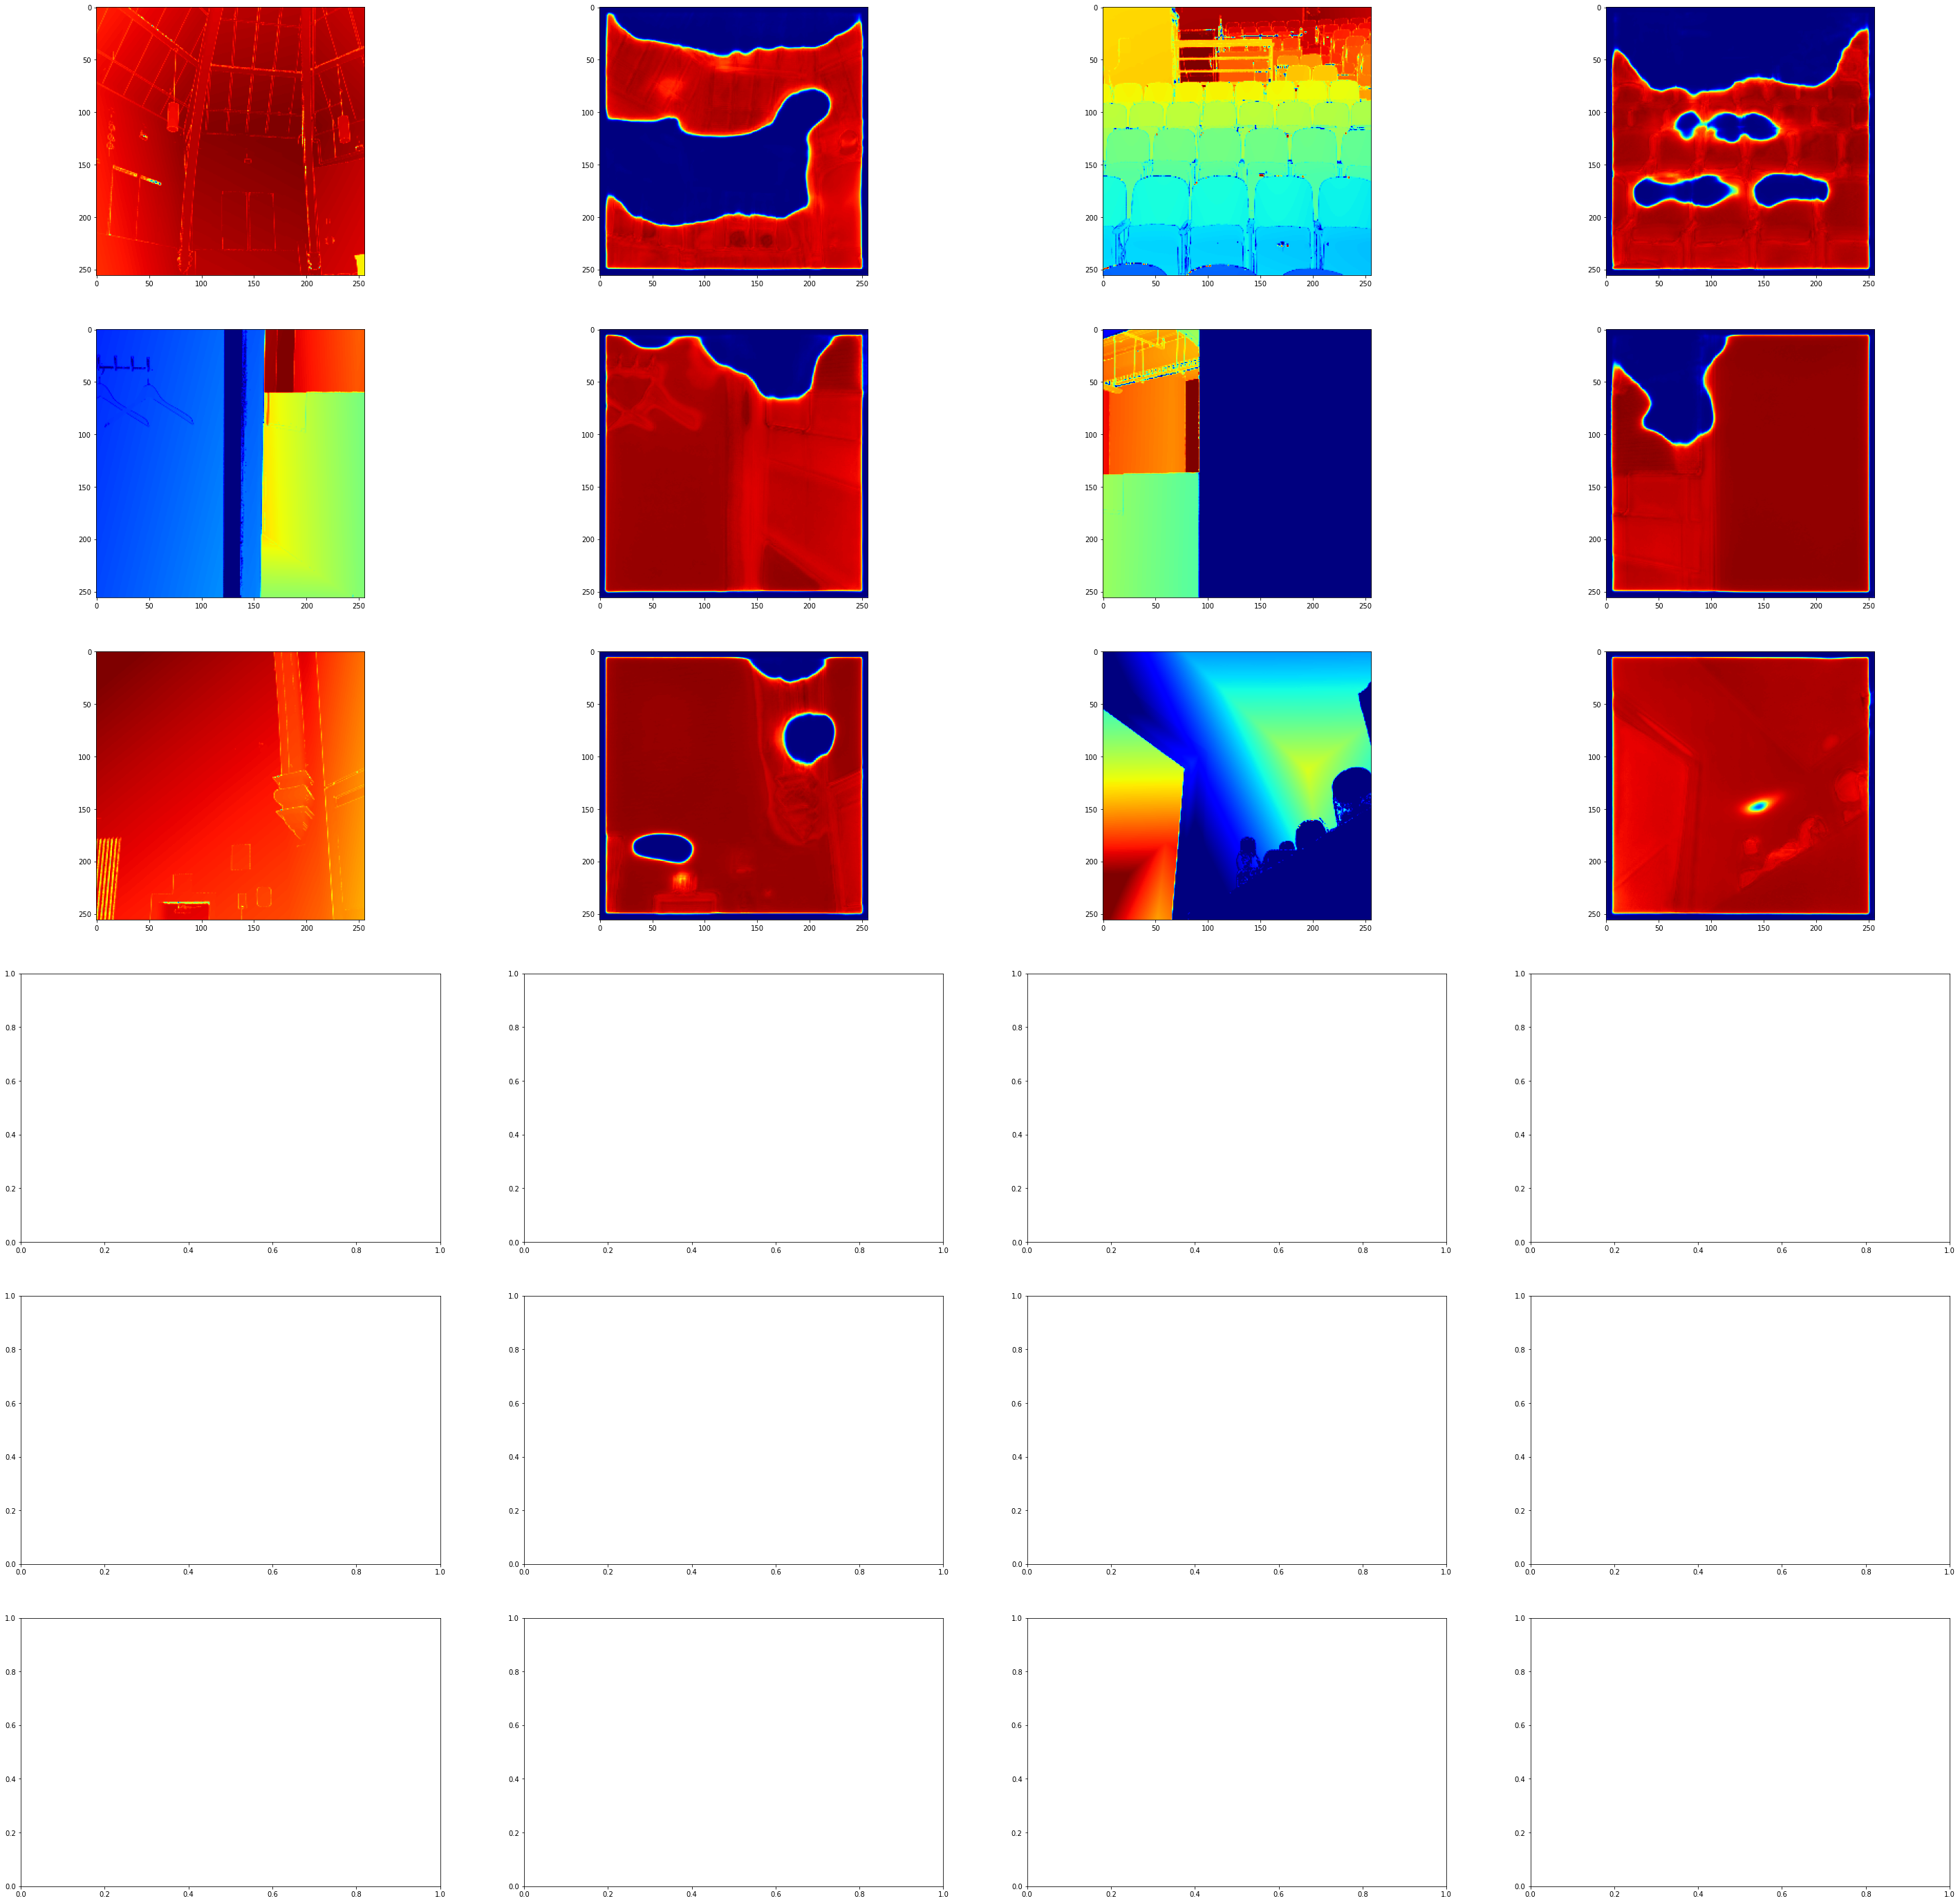

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[300:].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map_4col(test_loader, test=True, model=model_cir)


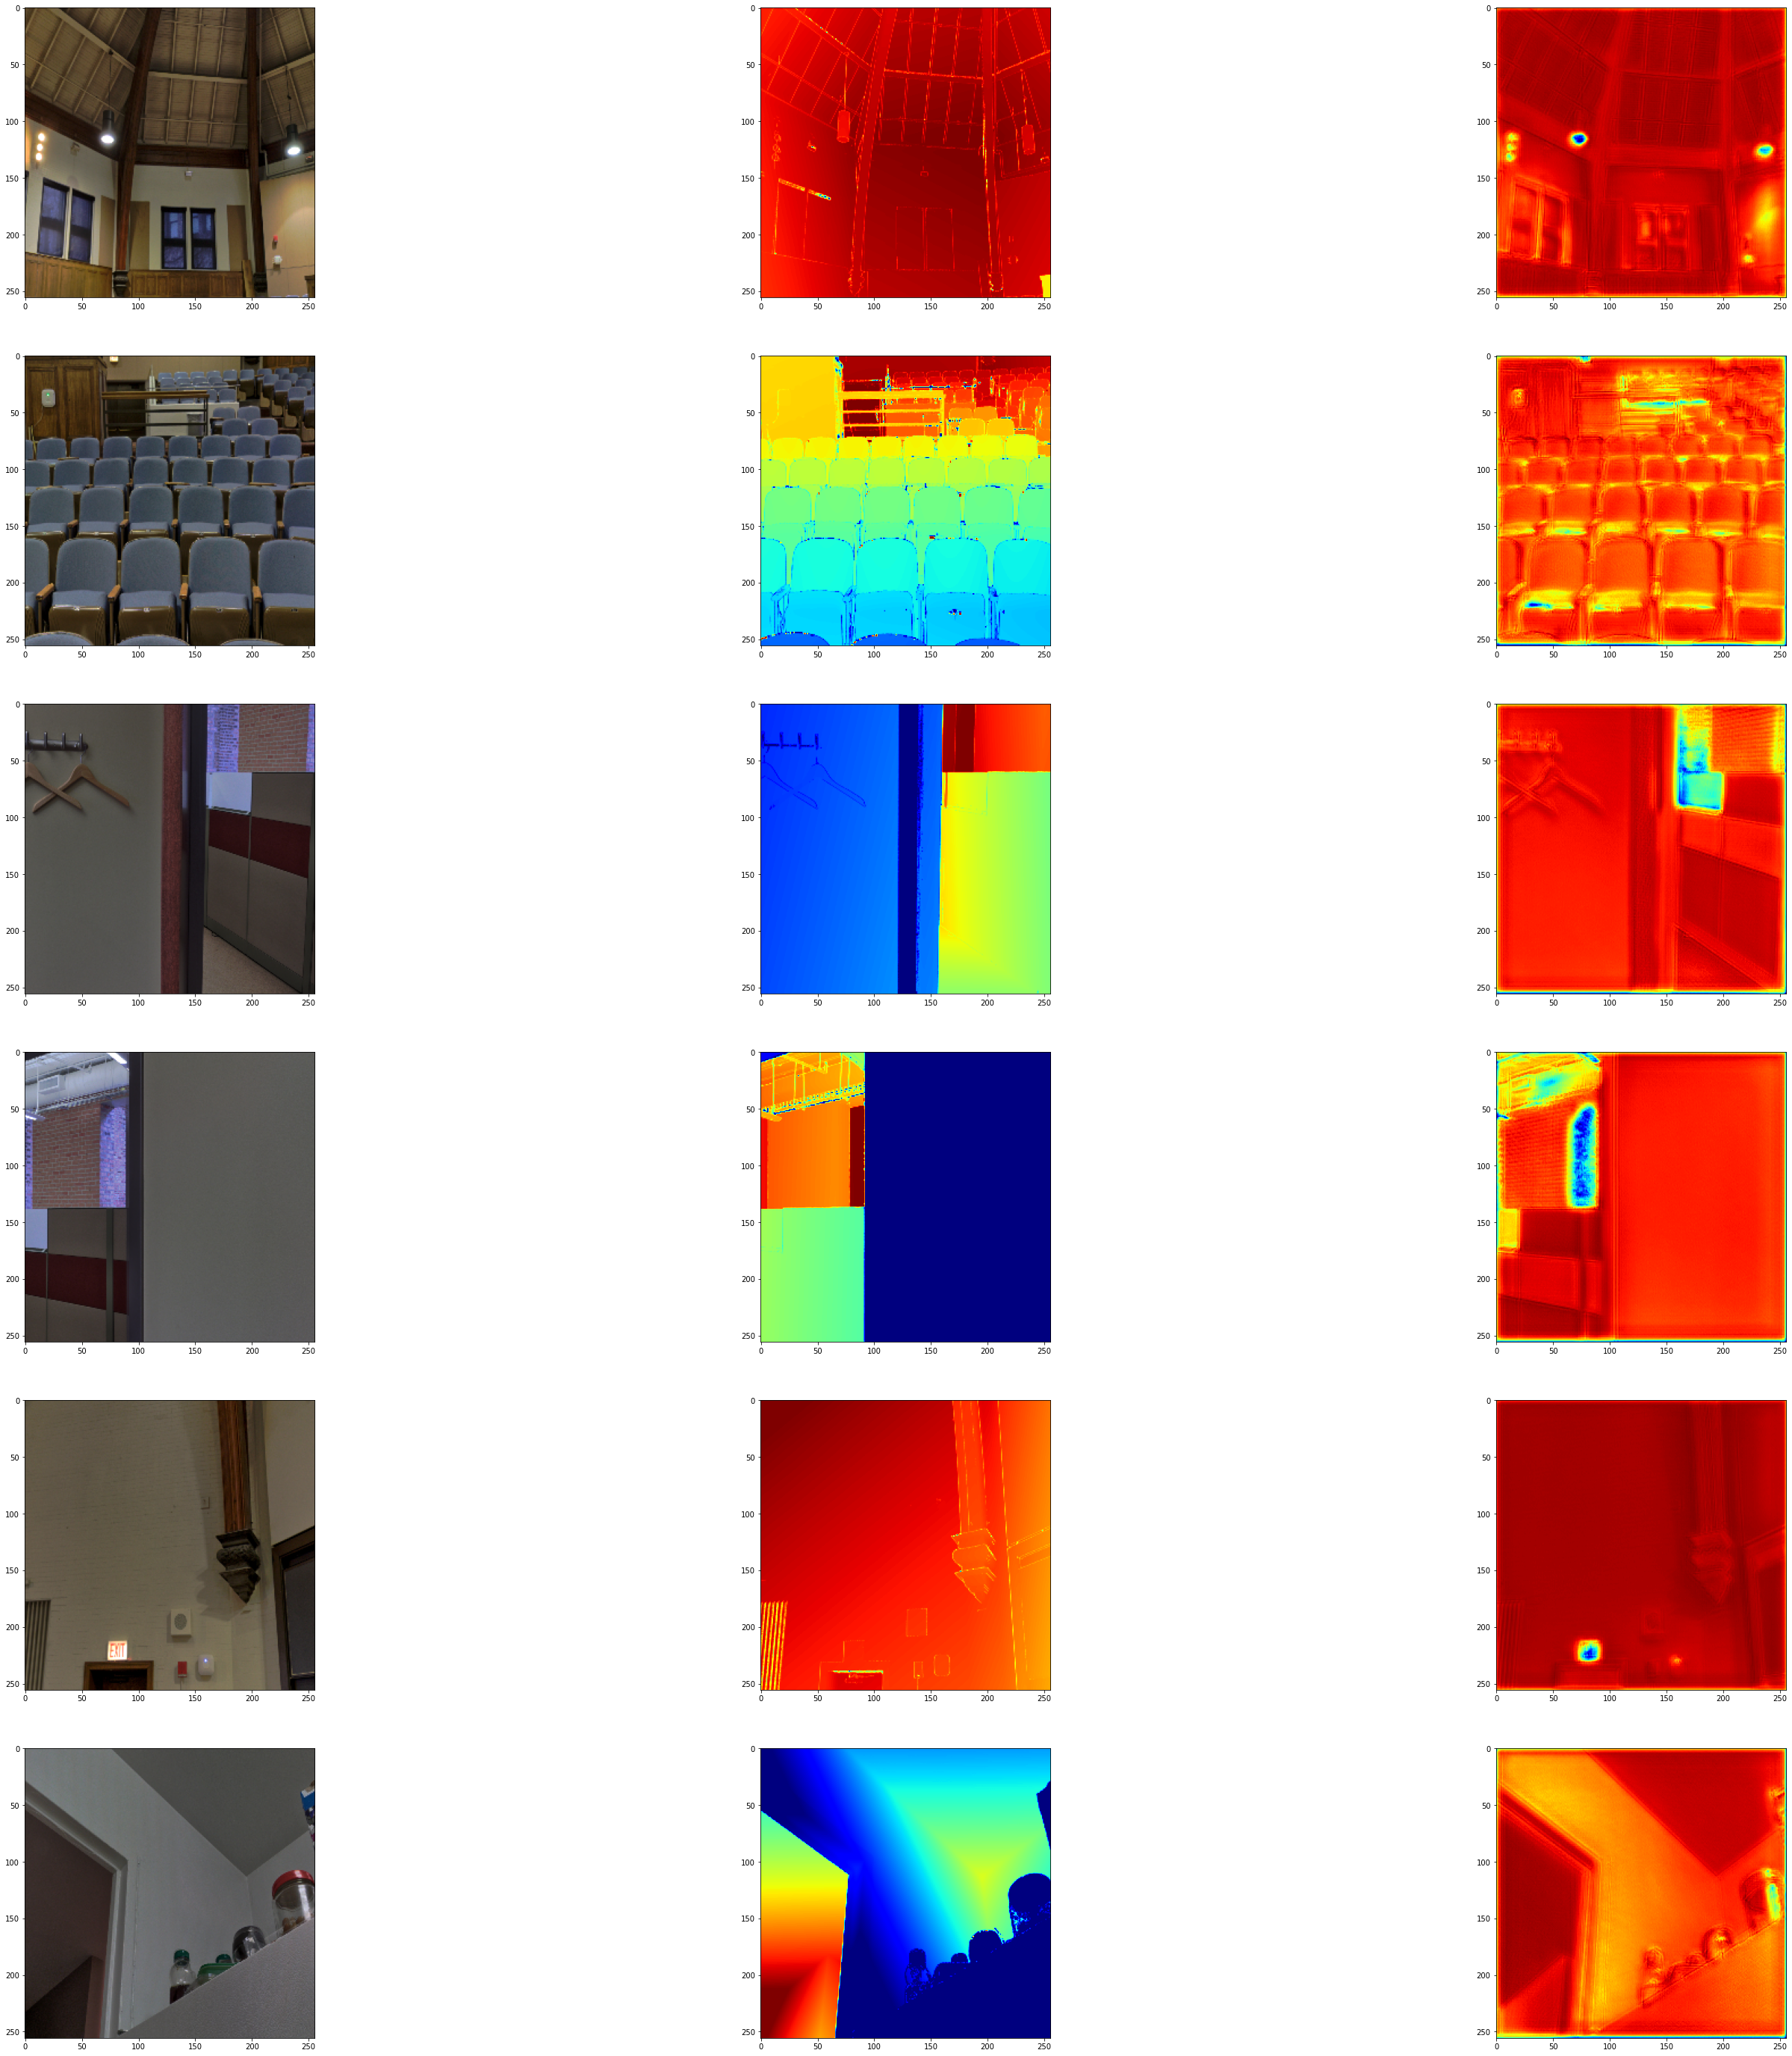

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            data=df[80:300].reset_index(drop="true"), batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)

In [ ]:
y_true = [[0., 1.], [1., 1.], [1., 1.]]
y_pred = [[1., 0.], [1., 1.], [-1., -1.]]
loss = tf.keras.losses.cosine_similarity(y_true, y_pred, axis=1)
loss.numpy()

array([-0.       , -0.9999998,  0.9999998], dtype=float32)